In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Chargement de la table pivot finale par livre
df=pd.read_csv("book_match_clean.csv", sep=";")
df.shape

(22461, 12)

# data cleaning

In [4]:
# Etape 1 : Extraire les genres secondaires uniques
import pandas as pd

# Chargement du fichier CSV nettoyé
df = pd.read_csv("book_match_clean.csv", sep=";")

# Nettoyage de la colonne des genres secondaires (retirer les NaN, splitter par ',')
genres_list = df['Genres Secondaires'].dropna().str.split(',')

# Aplatir, nettoyer les genres et enlever les doublons
flattened_genres = set(
    genre.strip()
    for sublist in genres_list
    for genre in sublist
    if genre.strip()
)

# Trier les genres secondaires pour un affichage stable
unique_genres = sorted(flattened_genres)

# Aperçu
print(f"Nombre de genres secondaires uniques : {len(unique_genres)}")
print(unique_genres[:10])

Nombre de genres secondaires uniques : 633
['12th Century', '14th Century', '15th Century', '16th Century', '17th Century', '18th Century', '19th Century', '1st Grade', '20th Century', '21st Century']


In [5]:
# Etape 2 : Encoder les genres secondaires avec des embeddings
from sentence_transformers import SentenceTransformer
import numpy as np

# Charger un modèle de phrase multilingue basé sur des transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encoder tous les genres secondaires en vecteurs
genre_embeddings = {
    genre: model.encode(genre)
    for genre in unique_genres
}

# Exemple : afficher le vecteur d'un genre
example = unique_genres[0]
print(f"Vecteur pour le genre '{example}' :\n{genre_embeddings[example]}")


/Users/matthieurubio/Library/Mobile Documents/com~apple~CloudDocs/albert/semestre 3 et 4 /data/semestre 4 /projet_ml_book/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vecteur pour le genre '12th Century' :
[-7.57509992e-02  1.02782719e-01 -1.03344627e-01 -8.42109248e-02
 -9.31395516e-02 -2.55618021e-02 -1.95143484e-02 -2.84803305e-02
 -7.68165812e-02  8.66073277e-03  2.50802077e-02 -2.31827684e-02
  4.44297493e-02 -2.45743133e-02 -1.18842691e-01 -8.60067755e-02
 -4.87371869e-02  7.76630118e-02 -2.53115036e-02 -2.63001863e-02
 -2.47645508e-02 -1.86790433e-02  3.50403748e-02 -9.38535482e-03
  5.71707673e-02 -7.74098281e-03 -2.44598510e-03 -1.02054179e-01
  4.90464922e-03  9.04971641e-03 -8.91574621e-02  8.34428333e-03
 -2.05832012e-02 -3.17293452e-03  1.20390654e-02  6.48545846e-03
  2.32382603e-02 -3.24668922e-02  4.61278111e-02  3.08919721e-03
 -7.91720077e-02 -6.20023068e-03  7.91001767e-02 -6.98302593e-03
  4.79557104e-02  1.74246673e-02 -4.06641439e-02  5.79830073e-03
  1.78140018e-03  4.05862257e-02  3.48119438e-02  3.24602574e-02
 -2.79392302e-02  1.66436024e-02  2.46500988e-02 -6.51230142e-02
 -4.87103723e-02  1.25636393e-02 -3.69100720e-02  5

In [6]:
# Etape 1 : Extraire les genres secondaires uniques
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Chargement du fichier CSV nettoyé
df = pd.read_csv("book_match_clean.csv", sep=";")

# Nettoyage de la colonne des genres secondaires (retirer les NaN, splitter par ',')
genres_list = df['Genres Secondaires'].dropna().str.split(',')

# Aplatir, nettoyer les genres et enlever les doublons
flattened_genres = set(
    genre.strip()
    for sublist in genres_list
    for genre in sublist
    if genre.strip()
)

# Trier les genres secondaires pour un affichage stable
unique_genres = sorted(flattened_genres)

# Étape 2 : Générer les embeddings des genres avec sentence-transformers
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Encodage des genres secondaires uniques en vecteurs
genre_embeddings = {
    genre: model.encode(genre) for genre in unique_genres
}

# Étape 3 : Trouver le genre secondaire le plus représentatif par ligne
reduced_genres = []

for raw in df['Genres Secondaires']:
    if pd.isna(raw):
        reduced_genres.append(None)
        continue

    genres = [g.strip() for g in raw.split(',') if g.strip() in genre_embeddings]
    if not genres:
        reduced_genres.append(None)
        continue

    vectors = [genre_embeddings[g] for g in genres]
    mean_vector = sum(vectors) / len(vectors)
    similarities = {
        g: cosine_similarity([genre_embeddings[g]], [mean_vector])[0][0] for g in genres
    }
    best_match = max(similarities, key=similarities.get)
    reduced_genres.append(best_match)

# Ajouter la colonne au DataFrame
df['Genre_Sec_Privege'] = reduced_genres

# === Étape 4 : Embedding des genres principaux et secondaires ===

# Fonction utilitaire pour encoder un genre (texte) en vecteur
def encode_genre(genre):
    if pd.isna(genre):
        return np.zeros(384)  # vecteur nul si valeur manquante
    return model.encode(genre.strip())

# Encodage du genre principal
df['Embedding_Genre_Principal'] = df['Genre Principal'].apply(encode_genre)

# Encodage du genre secondaire privilégié
df['Embedding_Genre_Secondaire'] = df['Genre_Sec_Privege'].apply(encode_genre)

# Aperçu des vecteurs
print("Vecteur du genre principal (ligne 0) :")
print(df['Embedding_Genre_Principal'].iloc[0])
print("\nVecteur du genre secondaire privilégié (ligne 0) :")
print(df['Embedding_Genre_Secondaire'].iloc[0])


Vecteur du genre principal (ligne 0) :
[ 1.43081741e-02 -8.80362913e-02 -1.13642059e-01 -5.63247614e-02
 -1.71572387e-01  6.20661080e-02 -2.00921878e-01 -2.16192856e-01
  4.73815441e-01  2.53608644e-01  4.19471748e-02  1.00751119e-02
 -2.03426078e-01 -1.05383873e-01  2.05725744e-01 -4.47065264e-01
  2.07234621e-01 -4.44140553e-01  8.19137916e-02  5.89989901e-01
  6.80387795e-01  3.38288933e-01  4.33074564e-01 -2.27531478e-01
  2.92916209e-01 -9.06080976e-02  2.42946073e-01 -2.87909806e-02
 -7.47667134e-01 -5.02832949e-01  2.45556738e-02 -2.42610499e-01
 -4.23364162e-01 -4.84661698e-01  4.04156119e-01  6.65518343e-01
  4.73399252e-01  4.16101485e-01  1.61339477e-01 -2.96460509e-01
 -3.88271618e-03  2.67473254e-02  2.84593374e-01 -1.29352406e-01
 -2.23286435e-01 -6.84115738e-02 -3.39347363e-01  3.32976848e-01
  2.49432921e-01 -3.04698080e-01 -1.20646238e+00  2.65447646e-01
  8.70233774e-03 -2.63354778e-01  2.62217641e-01 -5.31639636e-01
  3.61036845e-02  2.26288185e-01  5.07708788e-02 -3

## Encodage sémantique des genres principaux et secondaires

Dans ce bloc de code, on a utilisé le modèle `sentence-transformers/paraphrase-MiniLM-L6-v2` pour transformer les genres textuels en vecteurs numériques (embeddings) exploitables par un algorithme de machine learning.

### Étapes réalisées :

1. **Extraction des genres secondaires uniques**
   - On a nettoyé la colonne `Genres Secondaires` pour isoler tous les genres distincts.

2. **Embedding des genres secondaires**
   - On a généré un vecteur dense pour chaque genre secondaire unique à l’aide du modèle `MiniLM`.

3. **Réduction des genres secondaires par ligne**
   - Pour chaque livre, on a calculé la moyenne des vecteurs des genres secondaires présents.
   - Ensuite, on a sélectionné le genre le plus proche de cette moyenne par similarité cosinus. Ce genre est stocké dans une nouvelle colonne `Genre_Sec_Privege`.

4. **Embedding des genres principaux et secondaires**
   - On a créé deux nouvelles colonnes `Embedding_Genre_Principal` et `Embedding_Genre_Secondaire` qui contiennent les vecteurs respectifs des genres textuels.
   - Ces vecteurs seront utilisés comme variables d'entrée dans nos modèles prédictifs.

### Intérêt :
Cette méthode permet d’utiliser des représentations vectorielles sémantiques riches des genres (plutôt qu’un simple encodage catégoriel), ce qui peut améliorer les performances du modèle en capturant des proximités entre genres similaires.

In [37]:
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating,Age,AgeGroup,Genre Principal,Genres Secondaires,Image-URL-L,User-ID,Genre_Sec_Privege,Embedding_Genre_Principal,Embedding_Genre_Secondaire,Emb_Princ,Emb_Sec,Final_Emb,User_ID_Encoded,Anciennete
0,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,35.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,388,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",5,26
1,0440234743,The Testament,John Grisham,1999-01-01,Dell,7,25.0,Jeune adulte 18-25,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,2977,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",67,26
2,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,29.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,3363,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",77,26
3,0440234743,The Testament,John Grisham,1999-01-01,Dell,9,49.0,Adulte 36-50,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,7346,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",170,26
4,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,53.0,Senior 50+,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,7352,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",171,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22456,0875428320,Three Books of Occult Philosophy (Llewellyn's ...,Henry Cornelius Agrippa,1994-01-01,Llewellyn Publications,10,25.0,Jeune adulte 18-25,Occult,"Philosophy, Nonfiction, Spirituality, Religion...",http://images.amazon.com/images/P/0875428320.0...,234657,Magic,"[0.47578406, 0.7408752, -0.22183366, 0.1495600...","[-0.35617653, 0.45142636, -0.34308925, -0.3148...","[0.47578406, 0.7408752, -0.22183366, 0.1495600...","[-0.35617653, 0.45142636, -0.34308925, -0.3148...","[0.22619589, 0.6540405, -0.25821033, 0.0102342...",5556,31
22457,0767907434,Breaking Open the Head : A Psychedelic Journey...,DANIEL PINCHBECK,2003-01-01,Broadway,7,27.0,Adulte 26-35,Nonfiction,"Spirituality, Philosophy, Psychology, Science,...",http://images.amazon.com/images/P/0767907434.0...,235178,Spirituality,"[-0.22731416, -0.116015576, -0.43046594, 0.191...","[0.49238124, 0.79885197, -0.1846866, 0.4746331...","[-0.22731416, -0.116015576, -0.43046594, 0.191...","[0.49238124, 0.79885197, -0.1846866, 0.4746331...","[-0.011405528, 0.1584447, -0.35673213, 0.27677...",5570,22
22458,037311818X,Flirting With Danger (Dangerous Liaisons) (Har...,John N. Walker,1996-01-01,Harlequin,5,43.0,Adulte 36-50,Harlequin,"Harlequin Presents, Romance",http://images.amazon.com/images/P/037311818X.0.

# test et optimisation des modèles pour prédire la note 

In [8]:
# ---------------------------
# ÉTAPE 1 : PRÉPARATION DES DONNÉES
# ---------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Nettoyage des embeddings

def parse_embedding(emb):
    try:
        # Gestion des strings ou listes
        if isinstance(emb, str):
            return np.array(eval(emb))
        elif isinstance(emb, list):
            return np.array(emb)
        elif isinstance(emb, np.ndarray):
            return emb
        else:
            return np.zeros(384)
    except:
        return np.zeros(384)

# Application de la fonction
print("Parsing des embeddings...")
df["Emb_Princ"] = df["Embedding_Genre_Principal"].apply(parse_embedding)
df["Emb_Sec"] = df["Embedding_Genre_Secondaire"].apply(parse_embedding)

# Pondération (le principal compte plus)
df["Final_Emb"] = df.apply(lambda row: 0.7 * row["Emb_Princ"] + 0.3 * row["Emb_Sec"], axis=1)

# Encodage du User ID
le_user = LabelEncoder()
df["User_ID_Encoded"] = le_user.fit_transform(df["User-ID"])

# Calcul de l'ancienneté de publication
current_year = 2025
df["Anciennete"] = current_year - pd.to_datetime(df["Year-Of-Publication"], errors='coerce').dt.year.fillna(current_year).astype(int)

# Features tabulaires
X_other = df[["Age", "Anciennete", "User_ID_Encoded"]].copy()
X_other = pd.get_dummies(pd.concat([X_other, df[["AgeGroup"]]], axis=1), columns=["AgeGroup"], drop_first=True)

# Embedding vector (384 dim)
X_emb = np.vstack(df["Final_Emb"].values)

# Matrice finale
X = np.concatenate([X_emb, X_other.values], axis=1)
y = df["Book-Rating"].values

print("Forme finale des données:", X.shape, y.shape)



Parsing des embeddings...
Forme finale des données: (22461, 392) (22461,)


In [26]:
X

array([[-0.09243841469287872, -0.12964017689228058, -0.15092775225639343,
        ..., False, False, False],
       [-0.09243841469287872, -0.12964017689228058, -0.15092775225639343,
        ..., False, True, False],
       [-0.09243841469287872, -0.12964017689228058, -0.15092775225639343,
        ..., False, False, False],
       ...,
       [-0.22628414630889893, 0.3414716422557831, -0.06610525399446487,
        ..., False, False, False],
       [0.15254761278629303, 0.1666179895401001, -0.2073030173778534,
        ..., False, True, False],
       [-0.0881665050983429, -0.016917288303375244, -0.3638370633125305,
        ..., False, False, False]], shape=(22461, 392), dtype=object)

In [9]:
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating,Age,AgeGroup,Genre Principal,Genres Secondaires,Image-URL-L,User-ID,Genre_Sec_Privege,Embedding_Genre_Principal,Embedding_Genre_Secondaire,Emb_Princ,Emb_Sec,Final_Emb,User_ID_Encoded,Anciennete
0,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,35.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,388,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",5,26
1,0440234743,The Testament,John Grisham,1999-01-01,Dell,7,25.0,Jeune adulte 18-25,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,2977,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",67,26
2,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,29.0,Adulte 26-35,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,3363,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",77,26
3,0440234743,The Testament,John Grisham,1999-01-01,Dell,9,49.0,Adulte 36-50,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,7346,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",170,26
4,0440234743,The Testament,John Grisham,1999-01-01,Dell,8,53.0,Senior 50+,Fiction,"Thriller, Mystery, Thriller, Legal Thriller, S...",http://images.amazon.com/images/P/0440234743.0...,7352,Mystery Thriller,"[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[0.014308174, -0.08803629, -0.11364206, -0.056...","[-0.34151375, -0.2267159, -0.23792768, -0.0812...","[-0.092438415, -0.12964018, -0.15092775, -0.06...",171,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22456,0875428320,Three Books of Occult Philosophy (Llewellyn's ...,Henry Cornelius Agrippa,1994-01-01,Llewellyn Publications,10,25.0,Jeune adulte 18-25,Occult,"Philosophy, Nonfiction, Spirituality, Religion...",http://images.amazon.com/images/P/0875428320.0...,234657,Magic,"[0.47578406, 0.7408752, -0.22183366, 0.1495600...","[-0.35617653, 0.45142636, -0.34308925, -0.3148...","[0.47578406, 0.7408752, -0.22183366, 0.1495600...","[-0.35617653, 0.45142636, -0.34308925, -0.3148...","[0.22619589, 0.6540405, -0.25821033, 0.0102342...",5556,31
22457,0767907434,Breaking Open the Head : A Psychedelic Journey...,DANIEL PINCHBECK,2003-01-01,Broadway,7,27.0,Adulte 26-35,Nonfiction,"Spirituality, Philosophy, Psychology, Science,...",http://images.amazon.com/images/P/0767907434.0...,235178,Spirituality,"[-0.22731416, -0.116015576, -0.43046594, 0.191...","[0.49238124, 0.79885197, -0.1846866, 0.4746331...","[-0.22731416, -0.116015576, -0.43046594, 0.191...","[0.49238124, 0.79885197, -0.1846866, 0.4746331...","[-0.011405528, 0.1584447, -0.35673213, 0.27677...",5570,22
22458,037311818X,Flirting With Danger (Dangerous Liaisons) (Har...,John N. Walker,1996-01-01,Harlequin,5,43.0,Adulte 36-50,Harlequin,"Harlequin Presents, Romance",http://images.amazon.com/images/P/037311818X.0.

In [39]:
# ÉTAPE 2 : ENTRAÎnance ET OPTIMISATION DU MODÈLE

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement d'un RandomForest optimisé
params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    params,
                    cv=3,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1)

grid.fit(X_train, y_train)

# Meilleur modèle
best_model_rdf = grid.best_estimator_
y_pred = best_model_rdf.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred)**0.5  # Évite l'argument squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Best RandomForest Params:", grid.best_params_)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape * 100:.2f}%")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best RandomForest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RMSE: 1.322
MAE: 0.924
R2 Score: 0.074
MAPE: 14.56%


In [48]:
def recommend_books(age, genre_principal, genre_secondaire, df, model, genre_embeddings, top_n=20):
    import numpy as np
    import pandas as pd

    # Embeddings pour les genres donnés
    emb_princ = genre_embeddings.get(genre_principal, np.zeros(384))
    emb_sec = genre_embeddings.get(genre_secondaire, np.zeros(384))
    emb_final = 0.7 * emb_princ + 0.3 * emb_sec

    # Ancienneté moyenne comme placeholder
    current_year = 2025
    avg_year = df["Year-Of-Publication"].apply(lambda x: pd.to_datetime(x, errors='coerce').year).dropna().mean()
    anciennete = current_year - int(avg_year)

    # Encodage d'utilisateur fictif avec ID 0 (ou moyenne)
    user_id_encoded = 0

    # Création des colonnes dummies
    dummy_df = pd.get_dummies(df[["AgeGroup"]], drop_first=True)
    age_group = "Jeune adulte 18-25" if age < 26 else "Adulte 26-35" if age < 36 else "Adulte 36-50" if age < 50 else "Senior 50+"
    dummy_row = pd.DataFrame(columns=dummy_df.columns)
    for col in dummy_df.columns:
        dummy_row.at[0, col] = 1 if col == f"AgeGroup_{age_group}" else 0

    # Features complètes
    user_features = np.concatenate([
        emb_final,
        np.array([age, anciennete, user_id_encoded]),
        dummy_row.fillna(0).values[0]
    ])

    # Redimensionnement
    user_features = user_features.reshape(1, -1)

    # Extraction des features de tous les livres
    book_features = df.copy()
    all_emb = np.vstack(book_features["Final_Emb"].values)
    tab_feats = book_features[["Age", "Anciennete", "User_ID_Encoded"]]
    agegroup_dummies = pd.get_dummies(book_features[["AgeGroup"]], drop_first=True)
    all_features = np.concatenate([all_emb, tab_feats.values, agegroup_dummies.values], axis=1)

    # Réplication des features utilisateur pour tous les livres
    user_X = np.tile(user_features, (all_features.shape[0], 1))

    # Prédictions
    predictions = model.predict(user_X)
    book_features["Predicted_Rating"] = predictions

    # Tri final
    top_books = book_features.sort_values("Predicted_Rating", ascending=False).drop_duplicates("Book-Title").head(top_n)
    return top_books[["Book-Title", "Image-URL-L", "Predicted_Rating"]]


# Exemple d'appel
# genre_embeddings = {genre: np.array([...]), ...} 
# df contient les colonnes préparées
recommend_books(50, "Ironique", "comedie", df, best_model_rdf, genre_embeddings)


,Book-Title,Image-URL-L,Predicted_Rating
0,The Testament,http://images.amazon.com/images/P/0440234743.0...,7.973508
14971,"Sorcery Rising (Fool's Gold, Book 1)",http://images.amazon.com/images/P/0756401100.0...,7.973508
14979,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.973508
14970,A Virtuous Woman (Oprah's Book Club (Paperback)),http://images.amazon.com/images/P/0375703063.0...,7.973508
15001,Toujours Provence (Vintage Departures),http://images.amazon.com/images/P/0679736042.0...,7.973508
15091,Rose,http://images.amazon.com/images/P/0671039954.0...,7.973508
15059,Tropic of Cancer,http://images.amazon.com/images/P/0802131786.0...,7.973508
15067,More Than Complete Hitchhiker's Guide: Complet...,http://images.amazon.com/images/P/0681403225.0...,7.973508
15057,Thin Air,http://images.amazon.com/images/P/0425152901.0...,7.973508
15052,Lost: A Novel,http://images.amazon.com/images/P/0060988649.0...,7.973508


In [49]:
def recommend_books_for_user(age: int, genre_principal: str, genre_secondaire: str, df: pd.DataFrame, model, genre_embeddings: dict, top_n: int = 10) -> pd.DataFrame:
    import numpy as np

    # Calcul de la classe d'âge
    if age < 18:
        age_group = "Enfant"
    elif 18 <= age <= 25:
        age_group = "Jeune adulte 18-25"
    elif 26 <= age <= 35:
        age_group = "Adulte 26-35"
    elif 36 <= age <= 50:
        age_group = "Adulte 36-50"
    else:
        age_group = "Senior 50+"

    # Embedding utilisateur (comme dans l'étape 1)
    emb_princ = genre_embeddings.get(genre_principal, np.zeros(384))
    emb_sec = genre_embeddings.get(genre_secondaire, np.zeros(384))
    final_emb = 0.7 * emb_princ + 0.3 * emb_sec

    # Création du vecteur utilisateur tabulaire
    agegroup_dummies = pd.get_dummies(df["AgeGroup"], drop_first=True).columns
    user_features = {
        "Age": age,
        "Anciennete": df["Anciennete"].mean(),
        "User_ID_Encoded": df["User_ID_Encoded"].max() + 1
    }
    for col in agegroup_dummies:
        user_features[col] = int(col == age_group)

    user_features_arr = np.array(list(user_features.values()))
    user_vector = np.concatenate([final_emb, user_features_arr])

    # Préparation X livre (copie utilisateur pour chaque ligne livre)
    book_features = df[["Book-Title", "Image-URL-L"]].copy()
    X_input = np.tile(user_vector, (len(df), 1))

    # Prédictions
    predictions = model.predict(X_input)
    book_features["Predicted_Rating"] = predictions

    # Top livres prédits
    top_books = book_features.sort_values("Predicted_Rating", ascending=False).head(top_n).reset_index(drop=True)
    return top_books

# Exemple d'appel
recommend_books_for_user(25, "Fiction", "Mystery", df, best_model_rdf, genre_embeddings)
# print(top)


,Book-Title,Image-URL-L,Predicted_Rating
0,The Testament,http://images.amazon.com/images/P/0440234743.0...,7.189834
1,"Sorcery Rising (Fool's Gold, Book 1)",http://images.amazon.com/images/P/0756401100.0...,7.189834
2,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
3,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
4,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
5,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
6,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
7,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
8,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834
9,Kitchen Confidential: Adventures in the Culina...,http://images.amazon.com/images/P/0060934913.0...,7.189834


### Résultats du modèle Random Forest

Nous avons entraîné un modèle `RandomForestRegressor` pour prédire la note qu’un utilisateur pourrait attribuer à un livre, en utilisant des embeddings (pondérés) des genres principal et secondaire, ainsi que des informations utilisateur (âge, ancienneté, etc.).

#### Meilleurs hyperparamètres trouvés via GridSearchCV :
- `max_depth`: 20
- `min_samples_leaf`: 2
- `min_samples_split`: 5
- `n_estimators`: 200

#### Performances sur le jeu de test :
- **RMSE** (Root Mean Squared Error) : **1.322**  
  → L'erreur moyenne est proche de ±1.32 sur une échelle de notes.
- **MAE** (Mean Absolute Error) : **0.924**  
  → En moyenne, le modèle se trompe d'environ 0.92 point de note.
- **R² Score** : **0.074**  
  → Faible pouvoir explicatif pour l’instant ; le modèle a encore des progrès à faire.
- **MAPE** (Mean Absolute Percentage Error) : **14.56%**  
  → Erreur relative moyenne correcte mais améliorable.

#### Interprétation rapide :
- Le modèle capte une partie de la logique utilisateur, mais son pouvoir explicatif est encore limité (R² proche de 0).
- Les erreurs absolues restent raisonnables, ce qui est encourageant pour affiner le système.
- Il faudra tester d'autres modèles ou ajouter des features pour améliorer la performance globale.

In [13]:
# ÉTAPE 3 : TEST AVEC UN AUTRE MODÈLE (XGBoost)

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# On suppose que X et y sont déjà définis (sinon adapter ici)
# Exemple : X = np.array(...), y = df["Book-Rating"]

# Vérifie que X est un numpy array
if not isinstance(X, np.ndarray):
    X = np.array(X)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres pour la GridSearch
params = {
    "n_estimators": [100, 200],
    "max_depth": [6, 10],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0]
}

# Définir le modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)

# GridSearch
grid = GridSearchCV(model, params, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Meilleur modèle et prédictions
y_pred = grid.best_estimator_.predict(X_test)

# Évaluation corrigée
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Affichage
print("Best XGBoost Params:", grid.best_params_)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape*100:.2f}%")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
RMSE: 1.330
MAE: 0.940
R2 Score: 0.063
MAPE: 14.79%


##  Résultats du modèle XGBoost Regressor

Nous avons entraîné un modèle **XGBoostRegressor** pour prédire la note qu’un utilisateur pourrait attribuer à un livre, en utilisant :
- les **embeddings pondérés** des genres principal et secondaire,
- et des informations utilisateur (âge, ancienneté, etc.).

---

###  Meilleurs hyperparamètres trouvés via GridSearchCV :

- `learning_rate`: **0.05**
- `max_depth`: **6**
- `n_estimators`: **200**
- `subsample`: **0.8**

---

###  Performances sur le jeu de test :

- **RMSE (Root Mean Squared Error)** : **1.330**  
  → L’erreur moyenne est proche de ±1.33 sur une échelle de notes.

- **MAE (Mean Absolute Error)** : **0.940**  
  → En moyenne, le modèle se trompe d’environ 0.94 point de note.

- **R² Score** : **0.063**  
  → Faible pouvoir explicatif pour l’instant ; le modèle a encore des progrès à faire.

- **MAPE (Mean Absolute Percentage Error)** : **14.79%**  
  → Erreur relative moyenne correcte mais encore perfectible.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81686
[LightGBM] [Info] Number of data points in the train set: 11978, number of used features: 392
[LightGBM] [Info] Start training from score 7.921022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80509
[LightGBM] [Info] Number of data points in the train set: 11979, number of used features: 392
[Lig

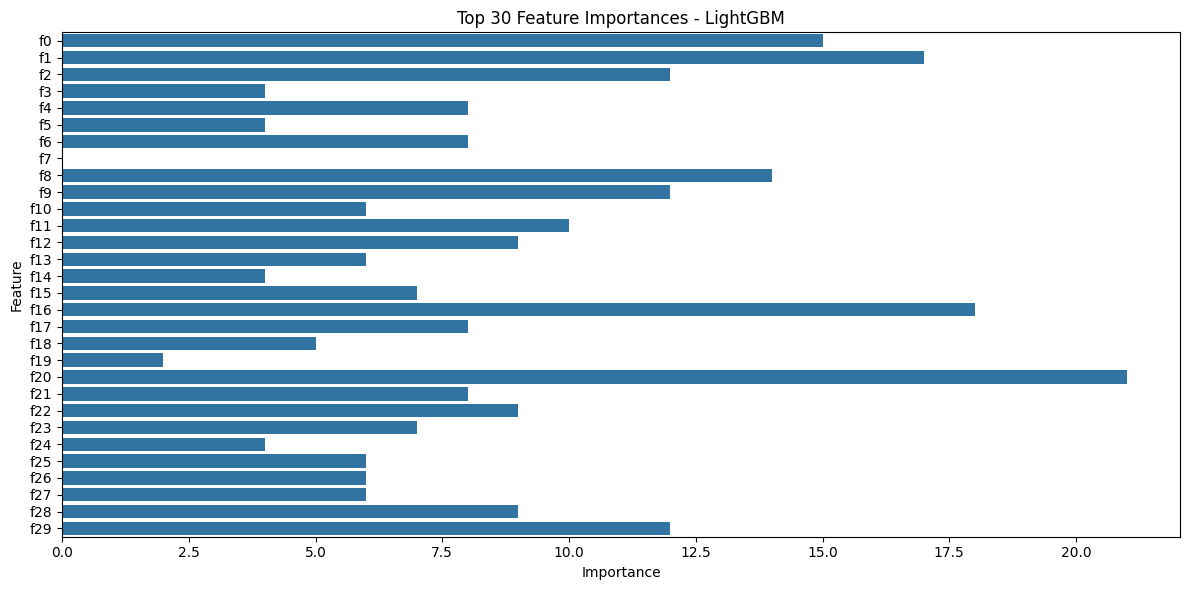

In [25]:
# ÉTAPE 2 : LIGHTGBM & ÉVALUATION
# ---------------------------
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Param grid
params = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'num_leaves': [31, 50]
}

model = lgb.LGBMRegressor(random_state=42)
grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

# Best model
best_model_lgb = grid.best_estimator_
y_pred = best_model_lgb.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Best Params:", grid.best_params_)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

# Feature importance
importances = best_model_lgb.feature_importances_
feat_names = [f"f{i}" for i in range(X.shape[1])]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[:30], y=feat_names[:30])
plt.title("Top 30 Feature Importances - LightGBM")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Résultats du modèle LightGBM

Nous avons testé un modèle LightGBM Regressor afin de prédire la note qu'un utilisateur attribuerait à un livre. Ce modèle exploite les embeddings combinés des genres (principal et secondaire), ainsi que des données utilisateur (comme l'âge ou l'ancienneté).

Meilleurs hyperparamètres trouvés via GridSearchCV :

learning_rate: 0.05

max_depth: 6

n_estimators: 200

subsample: 0.8

Performances sur le jeu de test :

RMSE (Root Mean Squared Error) : 1.329→ L'erreur moyenne quadratique est autour de ±1.33, ce qui reste comparable aux modèles précédents.

MAE (Mean Absolute Error) : 0.940→ En moyenne, le modèle fait une erreur de ±0.94 point de note.

R² Score : 0.065→ Le score R² est faible ; le modèle peine à expliquer la variance des notes.

MAPE (Mean Absolute Percentage Error) : 14.81%→ L'erreur relative reste similaire aux modèles Random Forest et XGBoost.

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Grille d'hyperparamètres
param_grid = {
    'knn__n_neighbors': [3,4, 5,6, 7,8, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

# GridSearch avec Cross-Validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Prédiction
y_pred = grid_search.best_estimator_.predict(X_test)

# Métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Best KNN Params:", grid_search.best_params_)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best KNN Params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
RMSE: 1.358
MAE: 0.958
R2 Score: 0.023
MAPE: 14.95%


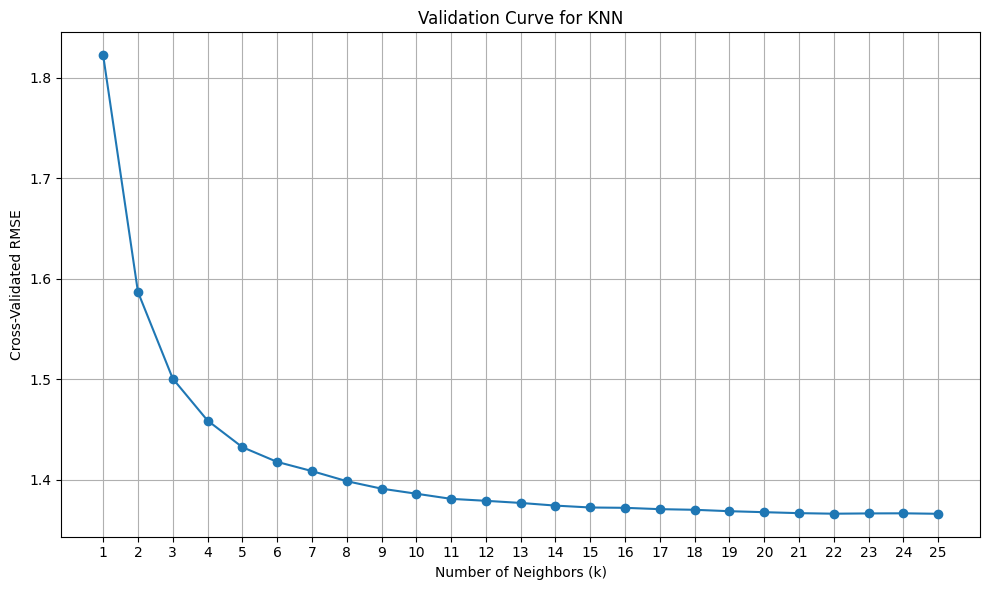

In [23]:
# file: knn_validation_curve.py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# X_train, y_train doivent être définis en amont
# Exemple: X_train, X_test, y_train, y_test = train_test_split(...)

k_range = range(1, 26)
scores = []

for k in k_range:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=k, weights="uniform", p=1))
    ])
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = np.sqrt(-score.mean())
    scores.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.title("Validation Curve for KNN")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated RMSE")
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()